In [1]:
from generating_data.generate_loaders import (
    create_Tang_multi_loaders,
    create_GM_test_multi_loaders
    )
from models.CNNs import flexCNN
from models.multi_class_trainer import multiTrainer

Tang_train_loader, Tang_val_loader, Tang_test_loader = create_Tang_multi_loaders('data/move_splits_pkl/opening_moves/Tang_opening_moves.pkl')
model =flexCNN(conv_layers=3, aff_layers=2, kernel_sizes=[3,3,3])
trainer = multiTrainer(net=model, train_loader=Tang_train_loader, val_loader=Tang_val_loader)

import torch.nn as nn
completed_model, best_model, train_losses, val_losses, train_acc, val_acc = trainer.train(
    optim_name='adamw',
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=10,
    learning_rate=0.001,
    momentum=0.9,
    step_size=5,
    learning_rate_decay=0.9,
    acc_frequency=1,
    verbose=True
)

100%|██████████| 288/288 [00:13<00:00, 21.51it/s]


New best model saved at epoch 1
Epoch 1/10: Train Loss = 1.2270, Train Acc = 0.4997, Val Loss = 1.0466, Val Acc = 0.5779


100%|██████████| 288/288 [00:11<00:00, 24.49it/s]


New best model saved at epoch 2
Epoch 2/10: Train Loss = 0.9630, Train Acc = 0.6202, Val Loss = 0.9015, Val Acc = 0.6531


100%|██████████| 288/288 [00:12<00:00, 22.32it/s]


New best model saved at epoch 3
Epoch 3/10: Train Loss = 0.8602, Train Acc = 0.6691, Val Loss = 0.8347, Val Acc = 0.6826


100%|██████████| 288/288 [00:13<00:00, 21.85it/s]


New best model saved at epoch 4
Epoch 4/10: Train Loss = 0.8036, Train Acc = 0.6917, Val Loss = 0.8011, Val Acc = 0.6964


100%|██████████| 288/288 [00:13<00:00, 20.70it/s]


New best model saved at epoch 5
Epoch 5/10: Train Loss = 0.7677, Train Acc = 0.7062, Val Loss = 0.7868, Val Acc = 0.7015


100%|██████████| 288/288 [00:13<00:00, 20.87it/s]


New best model saved at epoch 6
Epoch 6/10: Train Loss = 0.7304, Train Acc = 0.7214, Val Loss = 0.7578, Val Acc = 0.7143


100%|██████████| 288/288 [00:12<00:00, 23.74it/s]


New best model saved at epoch 7
Epoch 7/10: Train Loss = 0.7051, Train Acc = 0.7323, Val Loss = 0.7514, Val Acc = 0.7145


100%|██████████| 288/288 [00:12<00:00, 23.14it/s]


New best model saved at epoch 8
Epoch 8/10: Train Loss = 0.6815, Train Acc = 0.7403, Val Loss = 0.7339, Val Acc = 0.7204


100%|██████████| 288/288 [00:12<00:00, 22.95it/s]


New best model saved at epoch 9
Epoch 9/10: Train Loss = 0.6624, Train Acc = 0.7487, Val Loss = 0.7441, Val Acc = 0.7178


100%|██████████| 288/288 [00:12<00:00, 22.90it/s]


New best model saved at epoch 10
Epoch 10/10: Train Loss = 0.6419, Train Acc = 0.7559, Val Loss = 0.7282, Val Acc = 0.7244

Training completed! Best Validation Accuracy: 0.7244

The best model is the final model.


100%|██████████| 62/62 [00:06<00:00, 10.30it/s]


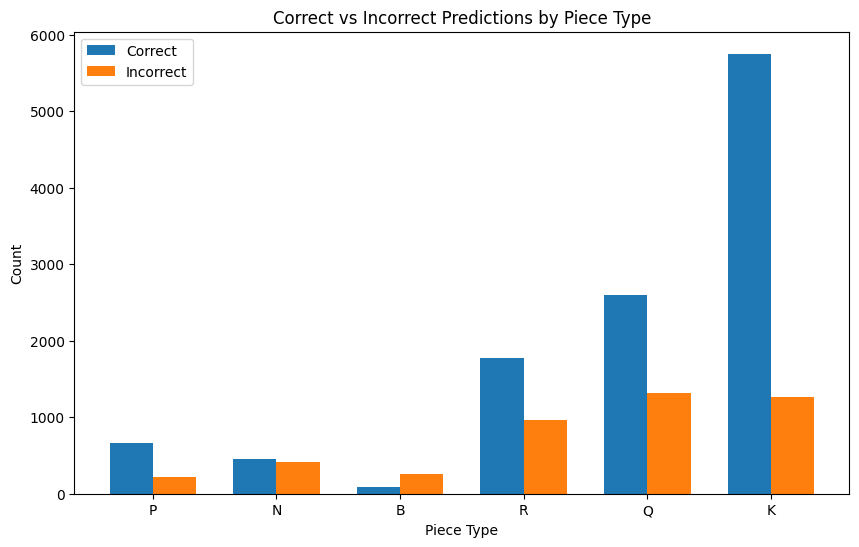


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     75.370582   75.370582     70.207116
1                 N     51.779564   51.779564     54.044338
2                 B     26.099707   26.099707     32.422587
3                 R     64.671533   64.671533     65.435746
4                 Q     66.369427   66.369427     67.600882
5                 K     81.965812   81.965812     80.340687
Weighted   Weighted     71.839736   71.839736     71.530328


In [3]:
def evaluate_per_piece_accuracy(model, test_loader, device):
    model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode
    class_correct = [0] * 6
    class_total = [0] * 6
    all_labels = []
    all_preds = []

    classes = ['P', 'N', 'B', 'R', 'Q', 'K']

    with torch.no_grad():
        for data in tqdm.tqdm(test_loader):
            # Ensure the input and labels are on the same device
            X, y = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)

            # Collect all labels and predictions for metrics
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Calculate per-class accuracy
            for i in range(len(y)):
                label = y[i].item()
                class_total[label] += 1
                if predicted[i] == y[i]:
                    class_correct[label] += 1

    # Ensure metrics are calculated correctly
    correct_counts = [class_correct[i] for i in range(6)]
    incorrect_counts = [class_total[i] - class_correct[i] for i in range(6)]
    accuracies = [(100 * class_correct[i] / class_total[i]) if class_total[i] > 0 else 0 for i in range(6)]
    recalls = [recall_score(all_labels, all_preds, labels=[i], average='macro') if class_total[i] > 0 else 0 for i in range(6)]
    f1_scores = [f1_score(all_labels, all_preds, labels=[i], average='macro') if class_total[i] > 0 else 0 for i in range(6)]

    # ✅ Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(classes))
    plt.bar(index, correct_counts, bar_width, label='Correct')
    plt.bar([i + bar_width for i in index], incorrect_counts, bar_width, label='Incorrect')
    plt.xlabel('Piece Type')
    plt.ylabel('Count')
    plt.title('Correct vs Incorrect Predictions by Piece Type')
    plt.xticks([i + bar_width / 2 for i in index], classes)
    plt.legend()
    plt.show()

    # ✅ Creating a DataFrame for reporting
    df = pd.DataFrame({
        'Piece Type': classes,
        'Accuracy (%)': accuracies,
        'Recall (%)': [r * 100 for r in recalls],
        'F1 Score (%)': [f * 100 for f in f1_scores]
    })

    # ✅ Calculate weighted metrics
    weighted_accuracy = accuracy_score(all_labels, all_preds) * 100
    weighted_recall = recall_score(all_labels, all_preds, average='weighted') * 100
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    # ✅ Add weighted metrics to the DataFrame
    df.loc['Weighted'] = ['Weighted', weighted_accuracy, weighted_recall, weighted_f1]

    print("\nOverall Accuracy Metrics:")
    print(df)

    return df

# Ensure both model and data are on the same device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
df_metrics = evaluate_per_piece_accuracy(best_model, Tang_test_loader, device)

100%|██████████| 85/85 [00:08<00:00,  9.69it/s]


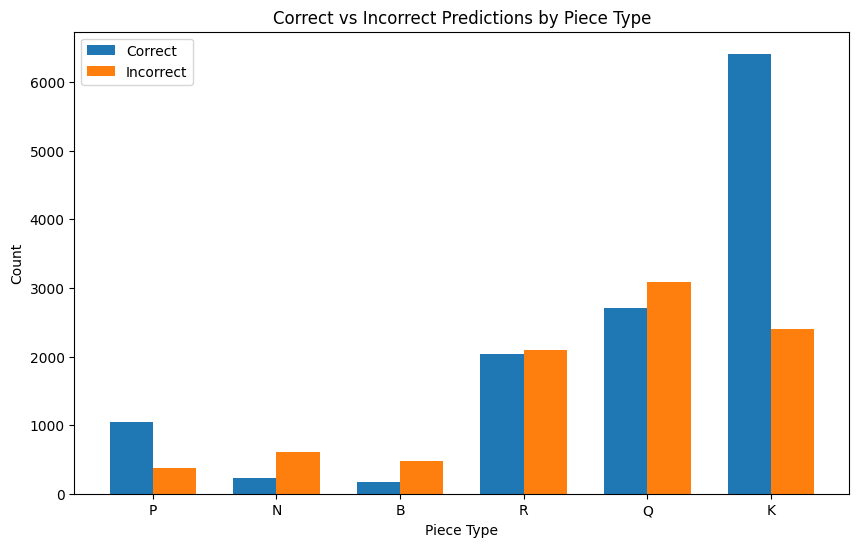


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     73.515024   73.515024     63.622619
1                 N     26.523297   26.523297     27.836991
2                 B     26.952527   26.952527     30.985915
3                 R     49.296458   49.296458     54.107309
4                 Q     46.764452   46.764452     50.887241
5                 K     72.787108   72.787108     67.162304
Weighted   Weighted     58.226328   58.226328     57.474986


In [4]:
Ediz_test_loader = create_GM_test_multi_loaders('data/move_splits_pkl/opening_moves/ediz_gurel_opening_moves.pkl')
df_metrics = evaluate_per_piece_accuracy(best_model, Ediz_test_loader, device)

100%|██████████| 85/85 [00:08<00:00, 10.08it/s]


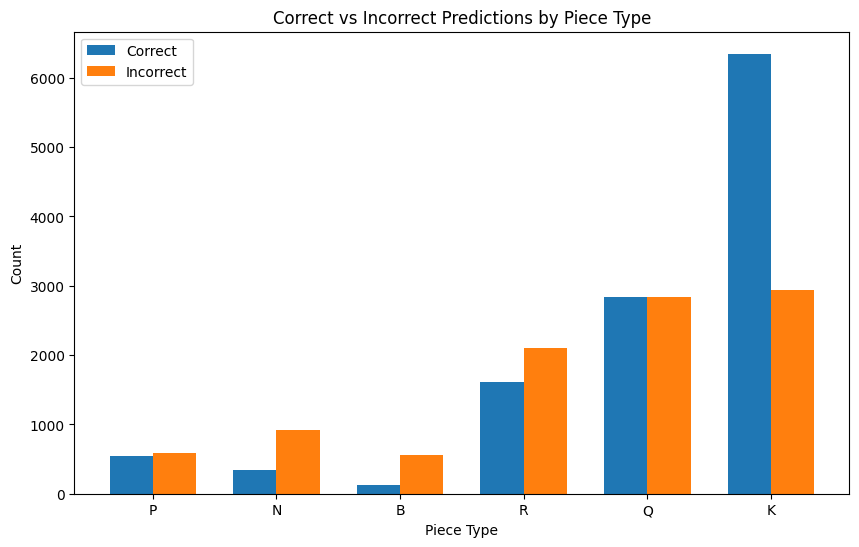


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     47.925861   47.925861     46.114650
1                 N     26.916933   26.916933     27.990033
2                 B     18.641618   18.641618     23.433243
3                 R     43.346829   43.346829     43.090958
4                 Q     49.938282   49.938282     50.584978
5                 K     68.357566   68.357566     66.947946
Weighted   Weighted     54.255221   54.255221     53.898165


In [5]:
Ediz_test_loader = create_GM_test_multi_loaders('data/move_splits_pkl/opening_moves/meneermandje_opening_moves.pkl')
df_metrics = evaluate_per_piece_accuracy(best_model, Ediz_test_loader, device)